## Image denoising by ResNets and Adverasarial Attack Generation on images
Consider the following denoising problem.  Let $x$ be a color image whose values are scaled to be within [0,1].  Let $y$ be a noisy version of $x$ where each color channel of each pixel is subject to additive Gaussian noise with mean 0 and variance $\sigma^2$. (We need to clip the values of $y$ in order to ensure it is a valid image). The denoising problem is to estimate $x$ given $y$.   
We refer the to definition of [Peak Signal-to-Noise Ratio(PSNR)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio), to determine what value of $\sigma$ corresponds to an expected PSNR between $x$ and $y$ of approximately 20 dB.  


We know that PSNR(Peak Signal to noise Ratio) is defined as the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation. Because many signals have a very wide dynamic range, PSNR is usually expressed as a logarithmic quantity using the decibel scale. Mathematically it is given as:   

$$PSNR = 20log_{10}\left(\dfrac{MAX_{f}}{\sqrt{MSE}}\right)$$
where MSE(Mean Squared Error) is given as:   
$$MSE = \dfrac{1}{mn}\sum \limits_{0}^{m-1} \sum \limits_{0}^{n-1} \lVert f(i,j)- g(i,j) \rVert^2$$
Here    
**f** represents the matrix data of our original image   
**g** represents the matrix data of our degraded image in question   
**m** represents the numbers of rows of pixels of the images and **i** represents the index of that row
**n** represents the number of columns of pixels of the image and **j** represents the index of that column    
**MAXf** is the maximum signal value that exists in our original “known to be good” image   
**$\sigma ^2 = MSE$**    
For our purpose,   
**MAXf** = 1 (since we have scaled the values between [0,1])   
**PSNR** = 20    
So, we have,     
$$ 20 = 20log_{10}\left(\dfrac{1}{\sqrt{MSE}}\right) $$
$$\implies 1 = log_{10}(1) - log_{10}\sqrt{MSE}$$
$$\implies 1 = 0 - 0.5log_{10}(MSE)$$
$$\implies -2 = log_{10}(MSE)$$
$$\implies MSE = 0.01$$
$$\implies \sigma = \sqrt{0.01}$$
$$\implies \sigma = 0.1$$

<div style="page-break-after: always"></div>

  
Creating a noisy version of the CIFAR-10 training and test dataset, such that it has additive Gaussian white noise with PSNR approximately 20 dB. <br>
Showing several pairs of images and their noisy version.   



In [1]:
# importing libraries
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation,UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import torch
import numpy as np
import os
import copy
import cv2
import numpy as np
import torch
from torch.autograd import Variable
from torchvision import models
import torch.nn as nn

In [2]:
# generating train, test for CIFAR10 dataset
(train,y_train),(test,y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
# shape of the train and test dataset
print(train.shape,test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


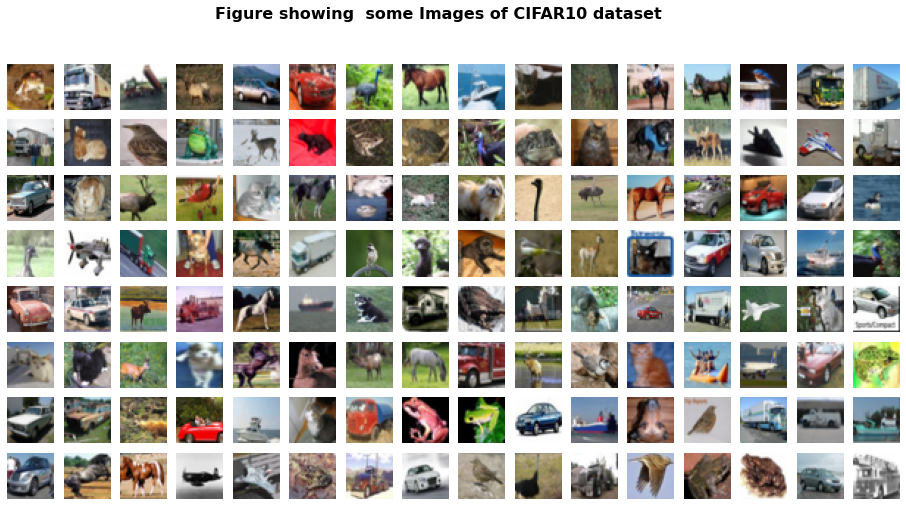

In [4]:
# plotting the images
plt.figure(figsize=(16,8))
plt.axis('off')
for i in range (128):
    
    plt.subplot(8,16,i+1)
    plt.imshow(train[i])
    plt.axis('off')
plt.suptitle('Figure showing  some Images of CIFAR10 dataset'
             ,size = 16,weight = 'bold')
plt.show()
   

In [5]:
# scaling the images in the range of [0,1]
train = train.astype(float)/255
test = test.astype(float)/255

In [6]:
print(train.mean(),test.mean())

0.4733630004850874 0.47658492059844665


In [7]:
print(train.max(),test.max())

1.0 1.0


In [8]:
# function to add noise to dataset
def get_gaussian_noise_data(data):
    noise = tf.random.normal(shape=tf.shape(data), mean=0.0, stddev=0.1, dtype=tf.float32)
    noisy_data = data + noise
    noisy_data = tf.clip_by_value(noisy_data, 0.0, 1)
    return noisy_data

In [9]:
# adding noise to the train dataset
train_noisy = get_gaussian_noise_data(train)
test_noisy = get_gaussian_noise_data(test)

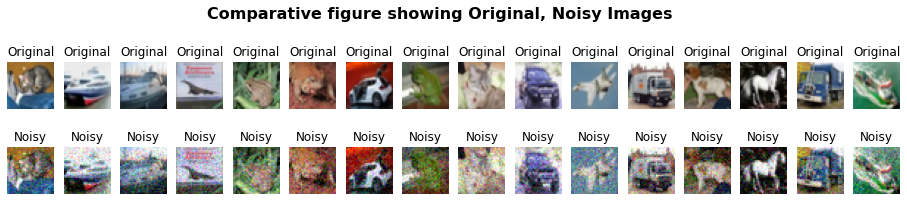

In [10]:
# plotting the original and noisy images with and without skip connections
plt.figure(figsize=(16,6))
plt.axis('off')
for i in range (16):
    plt.subplot(4,16,i+1)
    plt.imshow(test[i])
    plt.axis('off')
    plt.title("Original")
for i in range (16):
    plt.subplot(4,16,i+17)
    plt.imshow(test_noisy[i])
    plt.axis('off')    
    plt.title("Noisy")
 
plt.suptitle('Comparative figure showing Original, Noisy Images'
             ,size = 16,weight = 'bold')
plt.show()

In [11]:
# to calculate the psnr
psnr_images = tf.image.psnr(train, train_noisy, max_val=1)
#print(tf.math.reduce_max(psnr_images))
print(psnr_images)

tf.Tensor([20.146254 20.303831 20.873133 ... 20.677505 20.529434 20.11273 ], shape=(50000,), dtype=float32)


In [12]:
# calculate the psnr
psnr_images = tf.image.psnr(train, train_noisy, max_val=1)
print("Mean PSNR of noisy data" ,tf.math.reduce_mean(psnr_images, axis=None, keepdims=False, name=None).numpy())


Mean PSNR of noisy data 20.329588


<div style="page-break-after: always"></div>

Training a ResNet model to denoise noisy CIFAR-10 images.Taking a noisy 32x32 px image as an input to output a denoised 32x32 px image.  We determine the mean and standard deviation of the recovery PSNRs over the noisy test set.  

Creating a block of resnet with skip connection and two convolutional layers.   
It returns a tensor to be used as input to the next layer.



In [13]:
# creating a resnet block
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


At the beginning of each stage, the feature map size is halved (downsampled)by a convolutional layer with strides=2, while the number of filters isdoubled. Within each stage, the layers have the same number filters and the same number of filters.

In [14]:
def resnet_skip(input_shape, depth, num_classes=10):
    depth =20
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    for stack in range(3):                        # Instantiate the stack of residual units
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  
                strides = 2  
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
    x = UpSampling2D((4,4))(x)
    y = Conv2D(3,(3,3),padding = 'same')(x)
    output_image = Activation('sigmoid')(y)
    model = Model(inputs=inputs, outputs=output_image)
    return model


In [15]:
depth = 20
epoch = 10
num_classes = 10
batch_size = 32
data_augmentation = True

# Input image dimensions.
input_shape = train.shape[1:]
NUM_CLASSES = np.unique(y_train).shape[0]

In [16]:
# Converting class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

In [17]:
model = resnet_skip(input_shape=input_shape, depth=20)
model.compile(optimizer = 'adam',loss = 'mean_squared_error')

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model.fit(train_noisy,train,
          batch_size = 32,
         epochs =20,
          verbose =1,
          validation_data=(test_noisy,test),
          shuffle = True
         )

Epoch 1/20
1563/1563 [==============================] - 437s 278ms/step - loss: 0.0779 - val_loss: 0.0118
Epoch 2/20
1563/1563 [==============================] - 432s 276ms/step - loss: 0.0092 - val_loss: 0.0074
Epoch 3/20
1563/1563 [==============================] - 433s 277ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 4/20
1563/1563 [==============================] - 434s 277ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 5/20
1563/1563 [==============================] - 432s 277ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 6/20
1563/1563 [==============================] - 440s 281ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 7/20
1563/1563 [==============================] - 442s 283ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 8/20
1563/1563 [==============================] - 435s 278ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 9/20
1563/1563 [==============================] - 443s 284ms/step - loss: 0.0057 - val_loss: 0.0077
Epoch 10/20
1563/1563 [=======================

In [20]:
# generating denoised images on test set
denoised_images = model.predict(test_noisy)

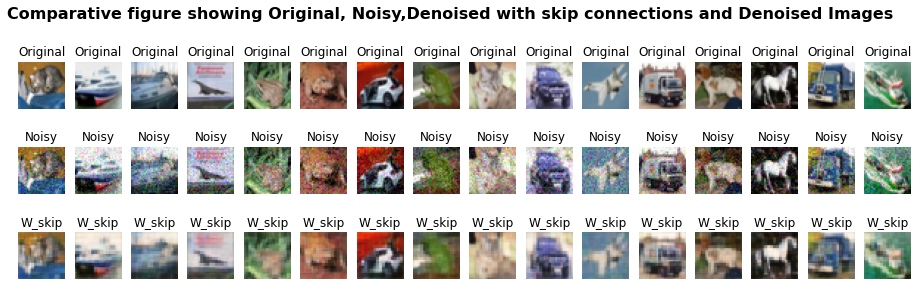

In [21]:
# plotting the original and noisy images with and without skip connections
plt.figure(figsize=(16,6))
plt.axis('off')
for i in range (16):
    plt.subplot(4,16,i+1)
    plt.imshow(test[i])
    plt.axis('off')
    plt.title("Original")
for i in range (16):
    plt.subplot(4,16,i+17)
    plt.imshow(test_noisy[i])
    plt.axis('off')    
    plt.title("Noisy")
for i in range (16):
    plt.subplot(4,16,i+33)
    plt.imshow(denoised_images[i])
    plt.axis('off')    
    plt.title("W_skip")

plt.suptitle('Comparative figure showing Original, Noisy,'+
             'Denoised with skip connections and Denoised Images'
             ,size = 16,weight = 'bold')
plt.show()

In [22]:
# to calculate the psnr
psnr_images_skip = tf.image.psnr(test_noisy,denoised_images, max_val=1)
#print(tf.math.reduce_max(psnr_images))
print(psnr_images_skip)


tf.Tensor([19.023281 18.920538 19.31773  ... 19.844212 18.655062 19.613937], shape=(10000,), dtype=float32)


In [23]:
print("Mean PSNR of denoised data is :" ,
      tf.math.reduce_mean(psnr_images_skip, axis=None, keepdims=False, name=None).numpy())
print("Standard deviation of denoised data with skip connections is :" ,
      tf.math.reduce_std(psnr_images_skip, axis=None, keepdims=False, name=None).numpy())


Mean PSNR of denoised data is : 19.199379
Standard deviation of denoised data with skip connections is : 0.5525762


<div style="page-break-after: always"></div>

### Repeating the previous task but without the skip connections in your model.   


In [24]:
# creating resnet without skip connections
inputs = Input(shape=input_shape)
x = Conv2D(64,(3,3),padding = 'same')(inputs)
x = Activation('relu')(x)
for i in range(15):
    x = Conv2D(64,(3,3),padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Conv2D(3,(3,3),padding = 'same')(x)
output = Activation('sigmoid')(x)
model_wo_skip = Model(inputs,output)
model_wo_skip.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [25]:
model_wo_skip.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_21 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 64)        3692

In [26]:
model_wo_skip.fit(train_noisy,train,
          batch_size = 32,
         epochs =20,
          verbose =1,
          validation_data=(test_noisy,test),
          shuffle = True
         )

Epoch 1/20
1563/1563 [==============================] - 1479s 945ms/step - loss: 0.0064 - val_loss: 0.0092
Epoch 2/20
1563/1563 [==============================] - 1426s 913ms/step - loss: 0.0029 - val_loss: 0.0069
Epoch 3/20
1563/1563 [==============================] - 1389s 889ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 4/20
1563/1563 [==============================] - 1430s 915ms/step - loss: 0.0022 - val_loss: 0.0048
Epoch 5/20
1563/1563 [==============================] - 1432s 916ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/20
1563/1563 [==============================] - 1470s 941ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/20
1563/1563 [==============================] - 1391s 890ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 8/20
1563/1563 [==============================] - 1454s 930ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 9/20
1563/1563 [==============================] - 1550s 992ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/20
1563/1563 [==============

In [27]:
denoised_images_wo_skip = model_wo_skip.predict(test_noisy)

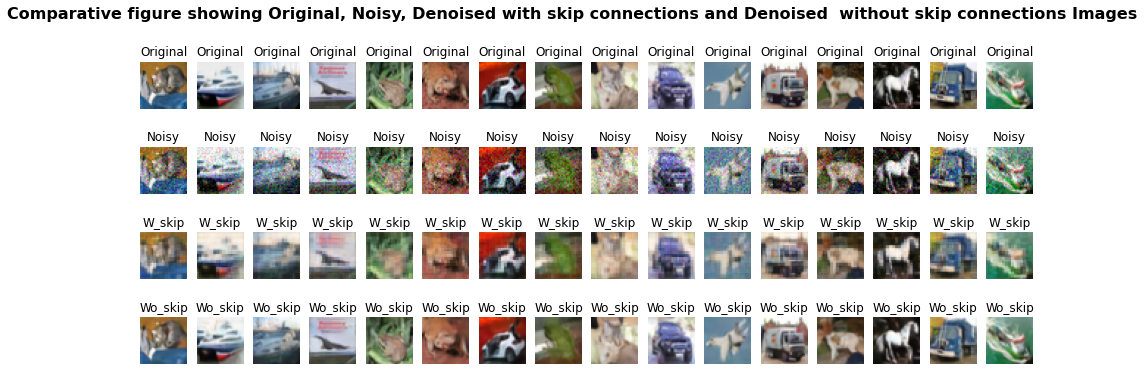

In [28]:
# plotting the original and noisy images with and without skip connections
plt.figure(figsize=(16,6))
plt.axis('off')
for i in range (16):
    plt.subplot(4,16,i+1)
    plt.imshow(test[i])
    plt.axis('off')
    plt.title("Original")
for i in range (16):
    plt.subplot(4,16,i+17)
    plt.imshow(test_noisy[i])
    plt.axis('off')    
    plt.title("Noisy")
for i in range (16):
    plt.subplot(4,16,i+33)
    plt.imshow(denoised_images[i])
    plt.axis('off')    
    plt.title("W_skip")
for i in range (16):
    plt.subplot(4,16,i+49)
    plt.imshow(denoised_images_wo_skip[i])
    plt.axis('off')    
    plt.title("Wo_skip") 
plt.suptitle('Comparative figure showing Original, Noisy,'+
             ' Denoised with skip connections and Denoised '+
            ' without skip connections Images',size = 16,weight = 'bold')
plt.show()

In [29]:
# to calculate the psnr
psnr_images_wo_skip = tf.image.psnr(test_noisy,denoised_images_wo_skip, max_val=1)
#print(tf.math.reduce_max(psnr_images))
print(psnr_images_wo_skip)

tf.Tensor([20.537613 21.14878  20.771944 ... 21.436863 20.875816 20.84244 ], shape=(10000,), dtype=float32)


In [30]:
print("Mean PSNR of denoised data without skip connections is :" ,
      tf.math.reduce_mean(psnr_images_wo_skip, axis=None, keepdims=False, name=None).numpy())
print("Standard deviation of denoised data without skip connections is :" ,
      tf.math.reduce_std(psnr_images_wo_skip, axis=None, keepdims=False, name=None).numpy())


Mean PSNR of denoised data without skip connections is : 20.911484
Standard deviation of denoised data without skip connections is : 0.35640523


<div style="page-break-after: always"></div>

## Adversarial examples   

We will use a pretrained classifier for ImageNet, such as AlexNet, ResNet101 from TorchVision.
Taking a picture of an object that belongs to one of the ImageNet classes and Resizing it
as appropriate. <br>
Sa target class that is different from the image’s true class was selected.<br>
An adversarial perturbation that is barely perceptible to the human eye and that results in the image
being misclassified as the target class is then generated.<br>


In [31]:
# obtaining pretrained models for Alexnet and Resnet
alexnet = models.alexnet(pretrained=True)
print(alexnet)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [32]:
from torchvision import transforms
from torchvision.transforms import (CenterCrop, Compose, Normalize, Resize,
                                    ToTensor)
transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [33]:
from PIL import Image
img = Image.open("car.jpg")

In [34]:
def preprocess(image):
    img_t = transform(image)
    batch_t = torch.unsqueeze(img_t, 0)
    processed_image = Variable(batch_t, requires_grad=True)
    return processed_image

In [35]:
batch_t = preprocess(img)
alexnet.eval()
out = alexnet(batch_t)

In [36]:
with open('imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

In [37]:
probabilities = torch.nn.functional.softmax(out[0], dim=0)
top_prob, top_catid = torch.topk(probabilities, 1)
print(classes[top_catid],": with a probability of :",top_prob.item())

817, sports_car : with a probability of : 0.4336002469062805


In [38]:
def to_array(tensor):
    tensor_ = tensor.squeeze()
    unnormalize_transform = Compose([Normalize(mean=[0, 0, 0],
                                               std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                     Normalize(mean=[-0.485, -0.456, -0.406],
                                               std=[1, 1, 1])])
    arr_ = unnormalize_transform(tensor_)
    arr = arr_.permute(1, 2, 0).detach().numpy()
    return arr
class FastGradientSignTargeted():
    def __init__(self, model, alpha):
        self.model = model
        self.model.eval()
        # Movement multiplier per iteration
        self.alpha = alpha
        # Create the folder to export images if not exists
        if not os.path.exists('../generated'):
            os.makedirs('../generated')

    def generate(self, original_image, org_class, target_class):
        target_tensor = Variable(torch.from_numpy(np.asarray([target_class])))
        ce_loss = nn.CrossEntropyLoss()
        processed_image = preprocess(original_image)
        for i in range(100):
            print('Iteration:', str(i))
            processed_image.grad = None
            out = self.model(processed_image)
            pred_loss = ce_loss(out, target_tensor)
            pred_loss.backward()
            processed_image.data = processed_image.data - self.alpha * torch.sign(processed_image.grad.data)
            
            confirmation_out = self.model(processed_image)
            _, confirmation_prediction = confirmation_out.data.max(1)
            confirmation_confidence = \
                nn.functional.softmax(confirmation_out)[0][confirmation_prediction].data.numpy()[0]
            confirmation_prediction = confirmation_prediction.numpy()[0]
            if confirmation_prediction == target_class:
                print('Original image was predicted as:', org_class,
                      'with adversarial noise converted to:', confirmation_prediction,
                      'and predicted with confidence of:', confirmation_confidence)
                break

        return processed_image,confirmation_confidence

In [39]:
target_example = 115 #sea slug, nudibranch
FGS_untargeted = FastGradientSignTargeted(alexnet, 1e-3)
processed_image,conf = FGS_untargeted.generate(img, top_catid, target_example)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Original image was predicted as: tensor([817]) with adversarial noise converted to: 115 and predicted with confidence of: 0.36110833


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


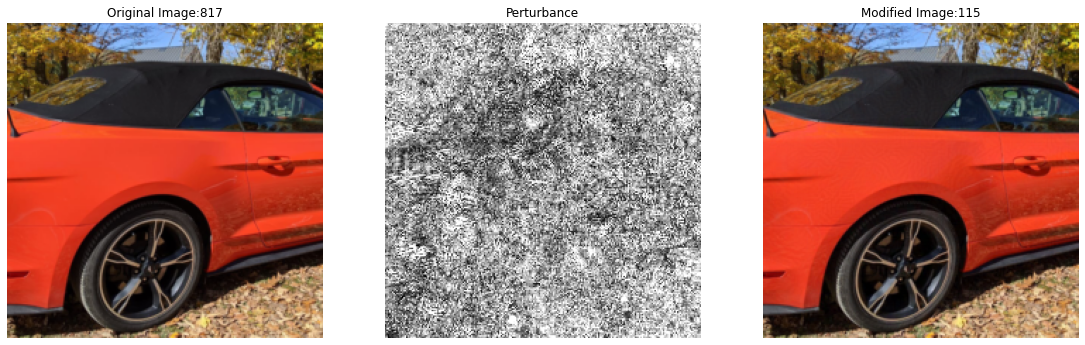

In [40]:
import numpy as np
_, (ax_orig, ax_diff, ax_new) = plt.subplots(1, 3, figsize=(19.20,10.80))
arr = to_array(preprocess(img))
new_arr = to_array(processed_image)
diff_arr = np.abs(arr - new_arr).mean(axis=-1)
diff_arr = diff_arr / diff_arr.max()

ax_orig.imshow(arr)
ax_new.imshow(new_arr)
ax_diff.imshow(diff_arr, cmap="gray")

ax_orig.axis("off")
ax_new.axis("off")
ax_diff.axis("off")

ax_orig.set_title("Original Image:817")
ax_new.set_title("Modified Image:115")
ax_diff.set_title("Perturbance")

plt.savefig("res_2.png")